In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from PIL import Image
from scipy.io import loadmat  
from scipy import stats  
from scipy.stats import multivariate_normal
import re
import glob
from operator import itemgetter 
import random

from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model
from processing_functions import * #

import os
os.chdir('../') # Go to the parent folder
from support_functions import *
from Autoencoder_Functions import *
from PCA_Functions import *
os.chdir('Yale_Faces_Data')

Using TensorFlow backend.


## Define Parameters

In [2]:
k = 20 # k to be used for the precision k metric

## Read Data

In [3]:
label_1_folder = [9,21]      # Images in this folder will be labeled as anomaly
target_folders = range(1,21) # Read these folders
data_path = "CroppedYale/"   # Source folder

# Read image matrix (n*m), labels (vector of m), and image size
imgs, labels, height, width = get_data(label_1_folder,target_folders,data_path)

544  images are above our threshold and thus removed from the list


### Load the Saved Deep Net Models
#### Load the saved model

In [4]:
# Specify the model config
encoder_layers_size, decoder_layers_size = get_deep_model_config(height*width)

# Load an existing model
img_size = imgs.shape[1]
autoencoder,encoder = compile_autoencoder(img_size,encoder_layers_size,decoder_layers_size) # Generate and Compile a Deep Autoencoder
autoencoder = load_model('model_autoencoder.h5') # Load the saved model

#### Second, set the weights of the encoder model with the first half of autoencoder model

In [5]:
n_encoder_layers = len(encoder_layers_size)
weights_encoder = autoencoder.get_weights()[0:n_encoder_layers] # The first half of the autoencoder model is an encoder model
encoder.set_weights(weights_encoder) # Set weights

In [6]:
print(encoder.summary())
print("\n The output shape of the encoder model: ")
print(encoder.output_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 504)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 252)               127260    
_________________________________________________________________
dense_2 (Dense)              (None, 126)               31878     
_________________________________________________________________
dense_3 (Dense)              (None, 63)                8001      
_________________________________________________________________
dense_4 (Dense)              (None, 31)                1984      
Total params: 169,123
Trainable params: 169,123
Non-trainable params: 0
_________________________________________________________________
None

 The output shape of the encoder model: 
(None, 31)


### Visualize the Reconstructed Image

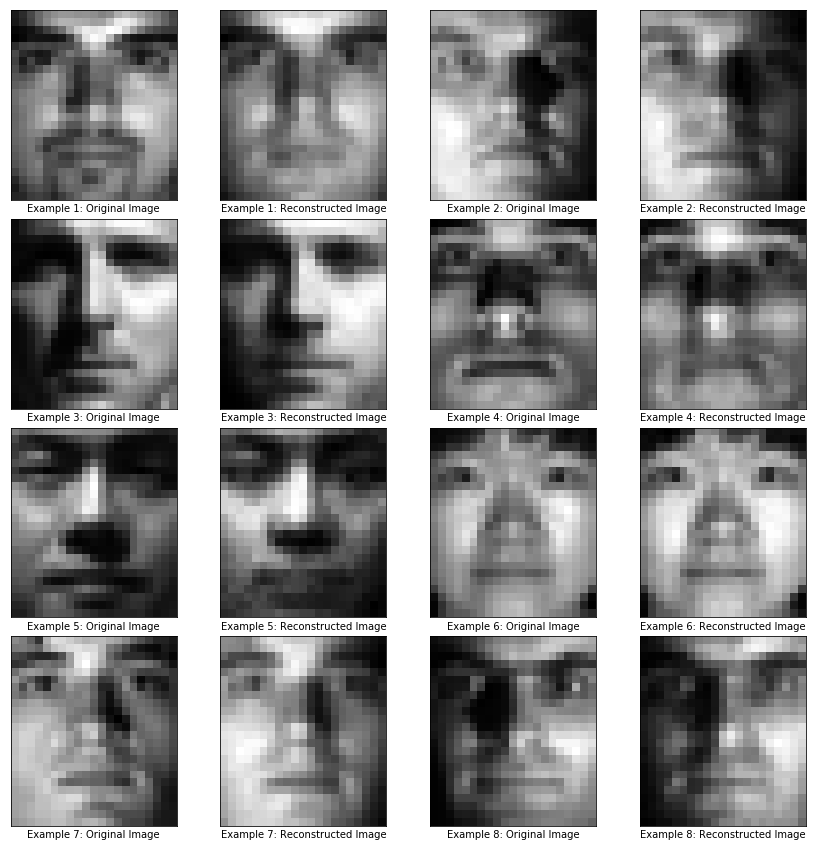

In [7]:
imgs_reconstructed,imgs = reconstruct_with_autoencoder(autoencoder,imgs,visual =True,height = height, width = width)

## Implement the Anomaly Detection 
### Split the data into the Training and Testing sets

In [8]:
# Split the images and labels
# By default: 80% in training and 20% in testing
train_ind, test_ind = split_training(labels)
x_train = imgs[train_ind,:]
x_test = imgs[test_ind,:]
x_train_reconstructed = imgs_reconstructed[train_ind,:]
x_test_reconstructed = imgs_reconstructed[test_ind,:]
labels_train = labels[train_ind]
labels_test = labels[test_ind]

### Method 1: Anomaly Detection with the Reconstruction Error

The higher the reconstruction error, the more likely the point will be an anomaly


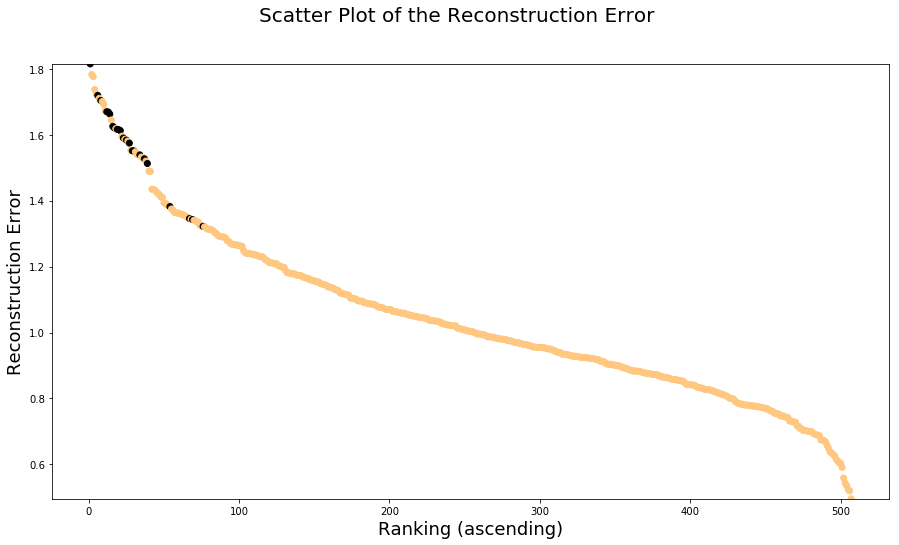

Training Results:
Precision: 48.7%
Recall: 82.6%
F-score: 61.3%
R-Precision (# R = 23): 52.2%
Precision@20: 50.0%

Testing Results:
Precision: 72.7%
Recall: 100.0%
F-score: 84.2%
R-Precision (# R = 8): 75.0%
Precision@20: 72.7%


In [9]:
train_test_with_reconstruction_error(x_train, x_train_reconstructed, x_test, x_test_reconstructed, labels_train, labels_test,k)

### Method 2: Anomaly Detection with the Gaussian Distribution

Finish evaluate Lambda: 0
Finish evaluate Lambda: 0.09
Finish evaluate Lambda: 0.18
Finish evaluate Lambda: 0.27
Finish evaluate Lambda: 0.36
Finish evaluate Lambda: 0.44999999999999996
Finish evaluate Lambda: 0.5399999999999999
Finish evaluate Lambda: 0.6299999999999999
Finish evaluate Lambda: 0.7199999999999999
Finish evaluate Lambda: 0.8099999999999998
Finish evaluate Lambda: 0.8999999999999998
Finish evaluate Lambda: 0.9899999999999998


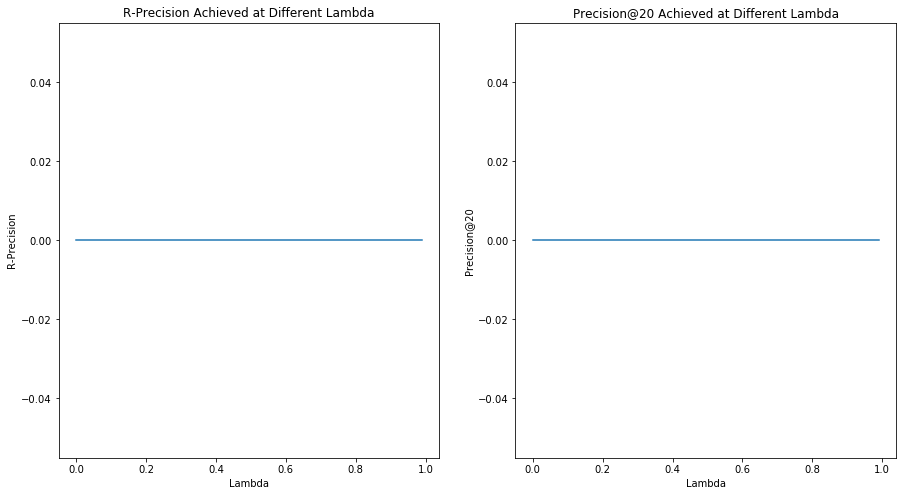

The best lambda selected from the cross validation is: 0


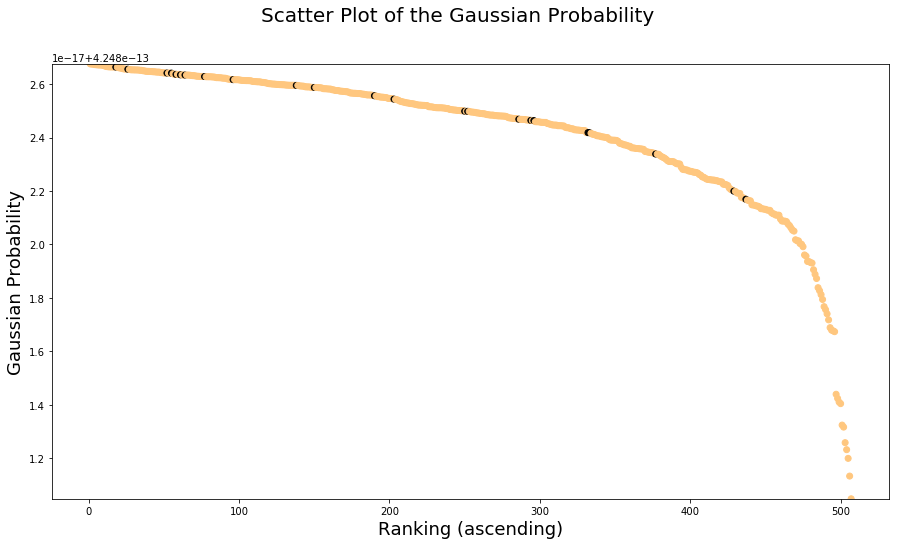

Training Results:
Precision: 4.5%
Recall: 95.7%
F-score: 8.6%
R-Precision (# R = 23): 0.0%
Precision@20: 0.0%

Precision: 5.7%
Recall: 87.5%
F-score: 10.0%
R-Precision (# R = 8): 12.5%
Precision@20: 10.0%


In [10]:
imgs_train_encoded = encode_data(encoder, x_train)
imgs_test_encoded = encode_data(encoder, x_test)
train_test_with_gaussian(imgs_train_encoded, imgs_test_encoded, labels_train, labels_test,k,whitened = True, lam = 0.9, plot_comparison = True)